In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import json
import numpy as np
from os import listdir
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
# import torch.nn.functional as F


class Classifier:
    def __init__(self, data_dir='flowers', model_name='densenet121', input_size=1024, hidden_layers=512,
                 output=102, loss_function_name='NLLLoss', optimizer_name='adam', epochs=15, dropout=.2,
                 learnrate=.002):

        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output = output
        self.epochs = epochs
        self.data_dir = data_dir

        models_dict = {'vgg13': models.vgg13(pretrained=True), 'vgg16': models.vgg16(pretrained=True),
                       'vgg19': models.vgg19(pretrained=True), 'alexnet': models.alexnet(pretrained=True),
                       'resnet18': models.resnet18(pretrained=True), 'densenet121': models.densenet121(pretrained=True)}

        classifier = nn.Sequential(nn.Linear(input_size, hidden_layers),
                                   nn.ReLU(),
                                   nn.Dropout(dropout),
                                   nn.Linear(hidden_layers, output),
                                   nn.LogSoftmax(dim=1))

        if model_name in models_dict:
            model = models_dict[model_name]
        elif model_name.split('_')[0] == 'old':
            #suggested = [pt for pt in listdir() if (pt.endswith('.pt') or pt.endswith('.pth')) and pt.split('_')[0] == model_name.split('_')[1]]
            suggested = [pt for pt in listdir() if pt.endswith('.pt') or pt.endswith('.pth')]
            print(suggested)
            ind = input("select by index which model to load: ")
            checkpoint = torch.load(suggested[ind])
            model = models_dict[model_name.split('_')[1]]
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            print(f'model name not exist.\nPlease try: {list(models_dict)} or "old_model_name" if you have a model')
            exit(0)

        # freeze model parameters to avoid backprop through them
        for param in model.parameters():
            param.requires_grad = False

        model.classifier = classifier
        model.class_to_idx = datasets.ImageFolder(self.data_dir + '/train').class_to_idx
        self.model = model

        loss_funcs = {'cross_entropy': nn.CrossEntropyLoss(), 'NLLLoss': nn.NLLLoss()}
        self.criterion = loss_funcs[loss_function_name]

        optimizers = {'adam': optim.Adam(model.classifier.parameters(), lr=learnrate),
                      'sgd': optim.SGD(model.classifier.parameters(), lr=learnrate)}
        self.optimizer = optimizers[optimizer_name]

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(device);


    def dataloader(self, train_transforms, test_transforms, batch_size=64):
        # Pass transforms in here, then run the next cell to see how the transforms look
        train_data = datasets.ImageFolder(self.data_dir + '/train', transform=train_transforms)
        test_data = datasets.ImageFolder(self.data_dir + '/test', transform=test_transforms)

        trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
        try:
            valid_data = datasets.ImageFolder(self.data_dir + '/valid', transform=train_transforms)
            validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
            return trainloader, validloader, testloader
        except:
            return trainloader, testloader

    def save_loss_vals(self, train_losses, test_losses, fname='train_test_losses.json'):
        loss_dict = {'train_losses': train_losses, 'test_losses': test_losses}
        with open(fname, 'w') as f:
            json.dump(loss_dict, f)

    def load_json_data(self, fname):
        with open(fname, 'r') as f:
            data_dict = json.load(f)
        return data_dict #['train_losses'], loss_dict['test_losses']

    def plot_loss_vals(self, train_loss, valid_loss):
        plt.plot(train_loss, label='Training loss')
        plt.plot(valid_loss, label='Testing loss')
        plt.legend(frameon=False);

    def save_model(self, fname='checkpoint.pth'):
        state = {
        'input_size': self.input_size,
        'hidden_size': self.hidden_layers,
        'output_size': self.output,
        'model_state_dict': self.model.state_dict(),
        'class_to_idx': self.model.class_to_idx,
        'optimizer_state_dict': self.optimizer.state_dict(),
        'epochs': self.epochs
        }
        torch.save(state, fname)

    def load_model(self, pth_fname='checkpoint.pth'):
        checkpoint = torch.load(pth_fname)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        input_size = checkpoint['input_size']
        hidden_size = checkpoint['hidden_size']
        output_size = checkpoint['output_size']
        self.model.class_to_idx: checkpoint['class_to_idx']
        epochs = checkpoint['epochs']
        return epochs, input_size, hidden_size, output_size





class TrainModel(Classifier):
    def __init__(self, data_dir='flowers', model_name='densenet121', input_size=1024,
                 hidden_layers=512, output=102, loss_function_name='NLLLoss',
                 optimizer_name='adam', epochs=15, dropout=.2,learnrate=.002):
        super().__init__(data_dir, model_name, input_size, hidden_layers, output,
                         loss_function_name, optimizer_name, epochs, dropout, learnrate)

    def train(self, trainloader, validloader, epochs, stop_threash=-2,
              print_every=60, save_checkpoint=True, save_loss=True, plot_loss=True):
        steps = 0
        train_loss = 0
        train_losses, valid_losses = [], []
        for e in range(epochs):
            for images, labels in trainloader:
                steps += 1
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()

                log_ps = self.model(images)
                loss = self.criterion(log_ps, labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                train_losses.append(train_loss)

                if steps % print_every == 0:
                    valid_loss = 0
                    accuracy = 0
                    self.model.eval()
                    with torch.no_grad():
                        for images, labels in validloader:
                            images, labels = images.to(device), labels.to(device)
                            log_ps = self.model(images)
                            loss = self.criterion(log_ps, labels)

                            valid_loss += loss.item()
                            valid_losses.append(valid_loss)

                            ps = torch.exp(log_ps)
                            top_p, top_class = ps.topk(1, dim=1)
                            equals = top_class == labels.view(*top_class.shape)
                            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                    print(f"Epoch: {e+1}/{epochs}.. "
                          f"Train loss: {train_loss/len(trainloader):.3f}.. "
                          f"Test loss: {valid_loss/len(validloader):.3f}.. "
                          f"Test accuracy: {accuracy/len(validloader):.3f}")
                    train_loss = 0
                    self.model.train()
                    # for early stopping
                    if (train_loss/len(trainloader) - valid_loss/len(validloader) < stop_threash):
                        break
        if save_checkpoint:
            self.save_model()
        if save_loss:
            self.save_loss_vals(train_losses, valid_losses)
        if plot_loss:
            self.plot_loss_vals(train_losses, valid_losses)


    def test(self, testloader):
        with torch.no_grad():
            test_loss = 0
            accuracy = 0
            self.model.eval()
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                log_ps = self.model(images)
                loss = self.criterion(log_ps, labels)

                test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()


        print(f"Test loss: {test_loss/len(testloader):.3f}.. "
              f"Test accuracy: {accuracy/len(testloader):.3f}")




class DataProcessing:
    def __init__(self):
        pass

    def transform(self, rotation=30, crop=224, resize=255, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        # TODO: Define transforms for the training data and testing data
        train_transforms = transforms.Compose([transforms.RandomRotation(rotation),
                                               transforms.RandomResizedCrop(crop),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean, std)])

        test_transforms = transforms.Compose([transforms.Resize(resize),
                                              transforms.CenterCrop(crop),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean, std)])
        return train_transforms, test_transforms


    def imshow(self, image, ax=None, title=None, normalize=True):
        """Imshow for Tensor."""
        if ax is None:
            fig, ax = plt.subplots()
        image = image.numpy().transpose((1, 2, 0))

        if normalize:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)

        plt.title(title)
        ax.imshow(image)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='both', length=0)
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        return ax

In [ ]:
# python train.py

In [30]:
train_transforms, test_transforms = DataProcessing().transform()

In [31]:
trainloader, validloader, testloader = Classifier().dataloader(train_transforms, test_transforms)

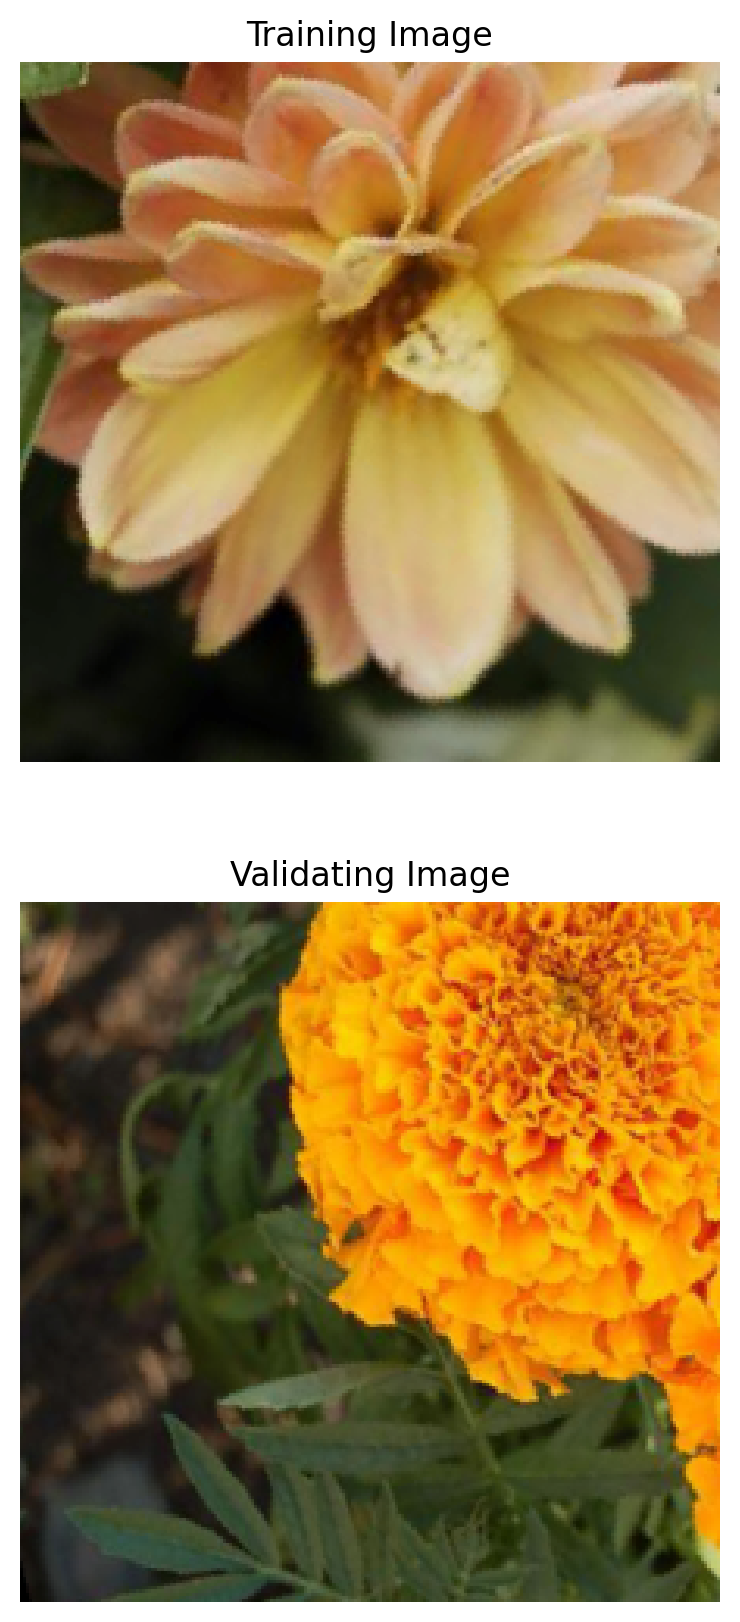

In [32]:
plt.figure(figsize=(6, 10))

ax = plt.subplot(2, 1, 1)
imgs, labels = next(iter(trainloader))
DataProcessing().imshow(imgs[0], ax, 'Training Image')

ax = plt.subplot(2, 1, 2)
imgs, labels = next(iter(validloader))
DataProcessing().imshow(imgs[0], ax, 'Validating Image');

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
# classifier = Classifier()

In [7]:
# model, criterion, optimizer = classifier.model, classifier.criterion, classifier.optimizer

In [2]:
classifier = TrainModel()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warni

In [3]:
classifier.model.class_to_idx

{'1': 0,
 '10': 1,
 '100': 2,
 '101': 3,
 '102': 4,
 '11': 5,
 '12': 6,
 '13': 7,
 '14': 8,
 '15': 9,
 '16': 10,
 '17': 11,
 '18': 12,
 '19': 13,
 '2': 14,
 '20': 15,
 '21': 16,
 '22': 17,
 '23': 18,
 '24': 19,
 '25': 20,
 '26': 21,
 '27': 22,
 '28': 23,
 '29': 24,
 '3': 25,
 '30': 26,
 '31': 27,
 '32': 28,
 '33': 29,
 '34': 30,
 '35': 31,
 '36': 32,
 '37': 33,
 '38': 34,
 '39': 35,
 '4': 36,
 '40': 37,
 '41': 38,
 '42': 39,
 '43': 40,
 '44': 41,
 '45': 42,
 '46': 43,
 '47': 44,
 '48': 45,
 '49': 46,
 '5': 47,
 '50': 48,
 '51': 49,
 '52': 50,
 '53': 51,
 '54': 52,
 '55': 53,
 '56': 54,
 '57': 55,
 '58': 56,
 '59': 57,
 '6': 58,
 '60': 59,
 '61': 60,
 '62': 61,
 '63': 62,
 '64': 63,
 '65': 64,
 '66': 65,
 '67': 66,
 '68': 67,
 '69': 68,
 '7': 69,
 '70': 70,
 '71': 71,
 '72': 72,
 '73': 73,
 '74': 74,
 '75': 75,
 '76': 76,
 '77': 77,
 '78': 78,
 '79': 79,
 '8': 80,
 '80': 81,
 '81': 82,
 '82': 83,
 '83': 84,
 '84': 85,
 '85': 86,
 '86': 87,
 '87': 88,
 '88': 89,
 '89': 90,
 '9': 91,
 '90

In [10]:
# model, criterion, optimizer = classifier.model, classifier.criterion, classifier.optimizer

In [40]:
classifier.test(testloader)

Test loss: 4.653.. Test accuracy: 0.007


In [41]:
classifier.load_model()

(0.002, 1024, 512, 102)

In [42]:
classifier.test(testloader)

Test loss: 0.710.. Test accuracy: 0.818


Epoch: 1/1.. Train loss: 0.439.. Test loss: 0.710.. Test accuracy: 0.816


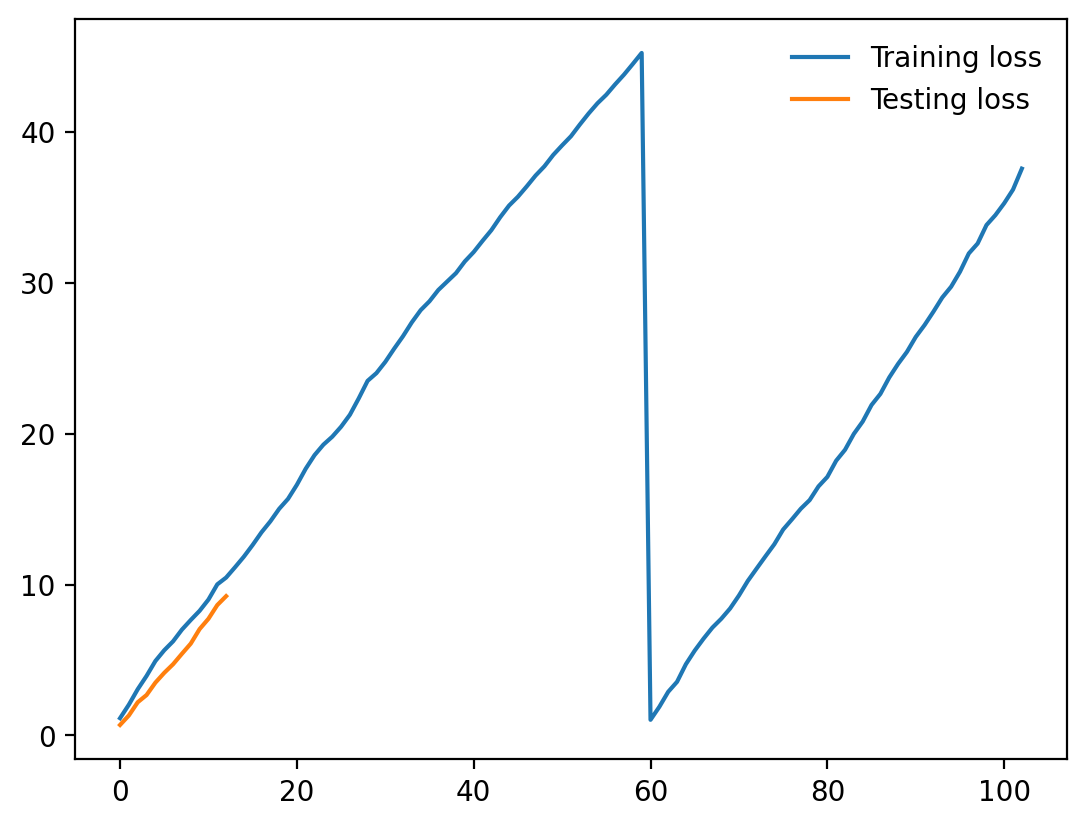

In [43]:
classifier.train(trainloader, validloader, 1)

In [44]:
classifier.test(testloader)

Test loss: 0.520.. Test accuracy: 0.874


In [4]:
classifier.load_model()

(15, 1024, 512, 102)

In [46]:
classifier.test(testloader)

Test loss: 0.520.. Test accuracy: 0.874


In [47]:
loss_dict = classifier.load_json_data('train_test_losses.json')
train_l = loss_dict['train_losses']
test_l = loss_dict['test_losses']

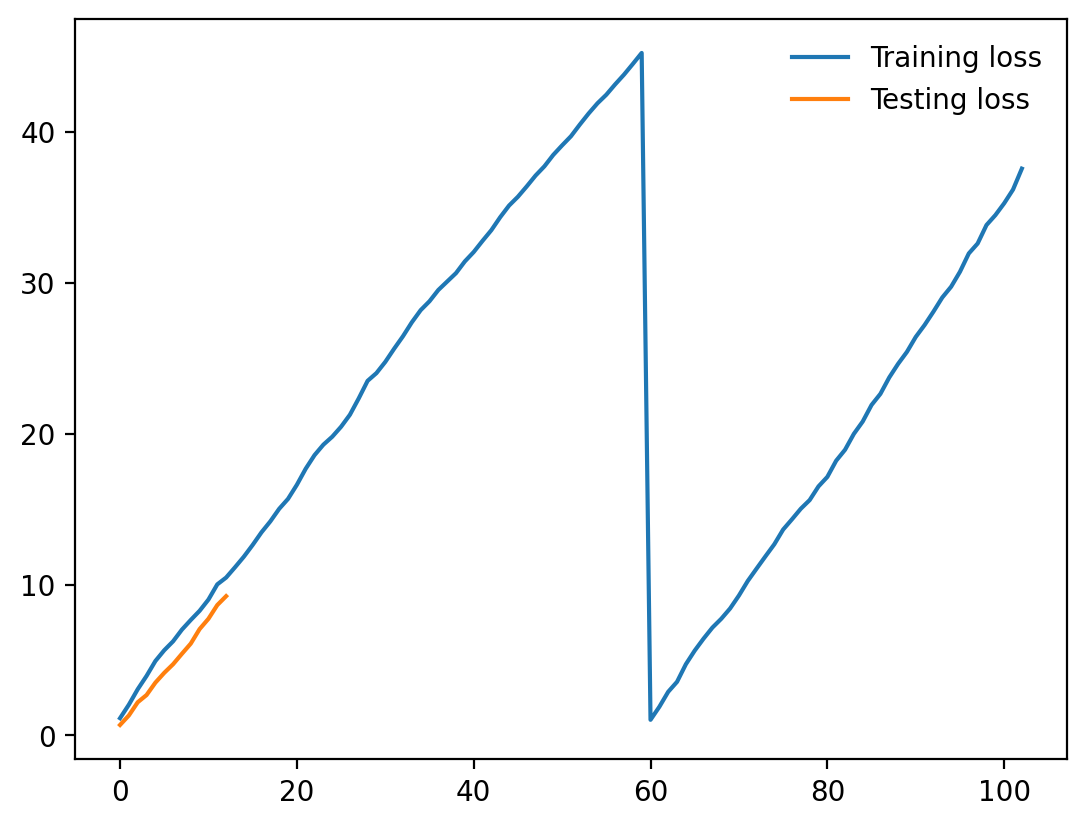

In [48]:
classifier.plot_loss_vals(train_l, test_l)

### All the classes are working, so now I'm going to load the model and continue training it

In [49]:
classifier_2 = TrainModel()

In [52]:
classifier_2.model.class_to_idx

{'1': 0,
 '10': 1,
 '100': 2,
 '101': 3,
 '102': 4,
 '11': 5,
 '12': 6,
 '13': 7,
 '14': 8,
 '15': 9,
 '16': 10,
 '17': 11,
 '18': 12,
 '19': 13,
 '2': 14,
 '20': 15,
 '21': 16,
 '22': 17,
 '23': 18,
 '24': 19,
 '25': 20,
 '26': 21,
 '27': 22,
 '28': 23,
 '29': 24,
 '3': 25,
 '30': 26,
 '31': 27,
 '32': 28,
 '33': 29,
 '34': 30,
 '35': 31,
 '36': 32,
 '37': 33,
 '38': 34,
 '39': 35,
 '4': 36,
 '40': 37,
 '41': 38,
 '42': 39,
 '43': 40,
 '44': 41,
 '45': 42,
 '46': 43,
 '47': 44,
 '48': 45,
 '49': 46,
 '5': 47,
 '50': 48,
 '51': 49,
 '52': 50,
 '53': 51,
 '54': 52,
 '55': 53,
 '56': 54,
 '57': 55,
 '58': 56,
 '59': 57,
 '6': 58,
 '60': 59,
 '61': 60,
 '62': 61,
 '63': 62,
 '64': 63,
 '65': 64,
 '66': 65,
 '67': 66,
 '68': 67,
 '69': 68,
 '7': 69,
 '70': 70,
 '71': 71,
 '72': 72,
 '73': 73,
 '74': 74,
 '75': 75,
 '76': 76,
 '77': 77,
 '78': 78,
 '79': 79,
 '8': 80,
 '80': 81,
 '81': 82,
 '82': 83,
 '83': 84,
 '84': 85,
 '85': 86,
 '86': 87,
 '87': 88,
 '88': 89,
 '89': 90,
 '9': 91,
 '90

In [50]:
classifier_2.test(testloader)

Test loss: 4.663.. Test accuracy: 0.011


In [53]:
classifier_2.load_model()

(15, 1024, 512, 102)

In [54]:
classifier_2.test(testloader)

Test loss: 0.520.. Test accuracy: 0.874


Epoch: 1/1.. Train loss: 0.353.. Test loss: 0.706.. Test accuracy: 0.804


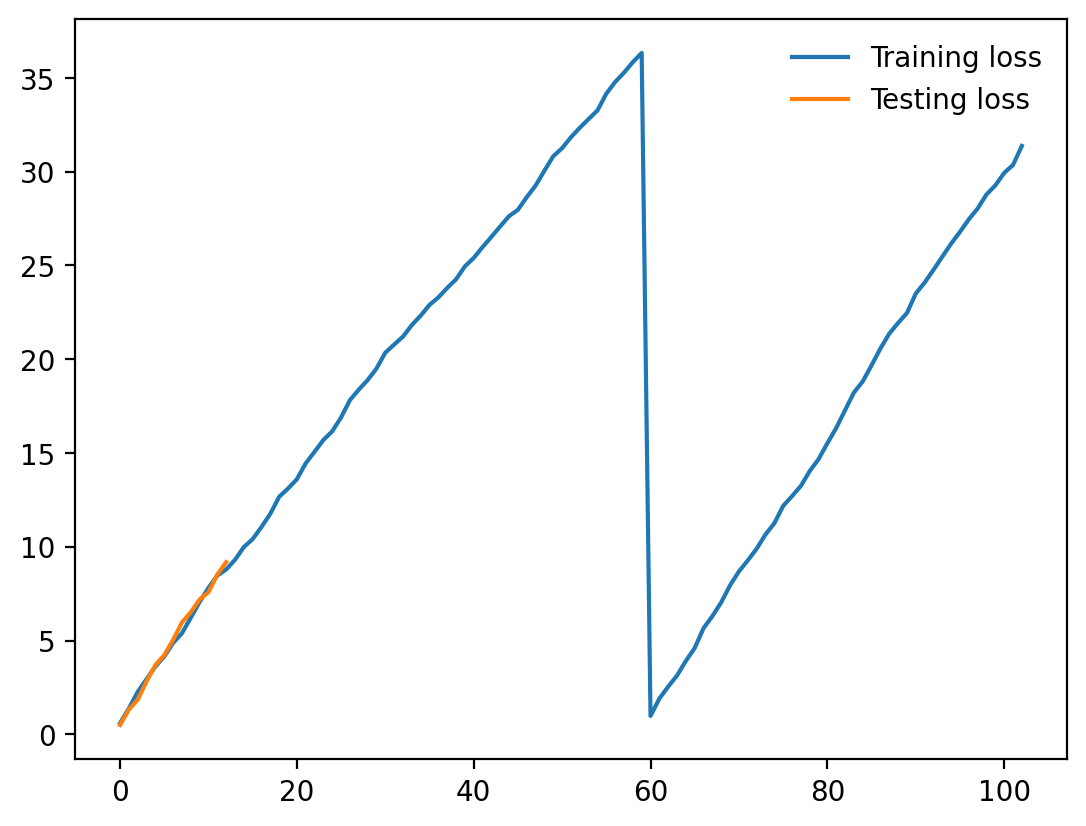

In [55]:
classifier_2.train(trainloader, validloader, 1)

In [56]:
classifier_2.test(testloader)

Test loss: 0.403.. Test accuracy: 0.895


In [57]:
classifier_2.load_model()

(15, 1024, 512, 102)

In [58]:
classifier_2.test(testloader)

Test loss: 0.403.. Test accuracy: 0.895


In [22]:
classifier.model.__class__.__name__

'DenseNet'

In [23]:
os.getcwd()

'/workspace/home/aipnd-project'

In [7]:
import os
from random import choice
from PIL import Image

class Prediction:
    def __init__(self):
        pass

    def random_image(self, img_dir):
        imgs_lst = [os.path.join(img_dir, cls, img) for cls in os.listdir(img_dir) for img in os.listdir(os.path.join(img_dir, cls))]
        random_img_path = choice(imgs_lst)
        return random_img_path

    def process_image(self, image):
        # TODO: Process a PIL image for use in a PyTorch model
        ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
            returns an Numpy array
        '''
        with Image.open(image) as im:
            # resize the image
            img = im.resize((256, 256))
            # center cropping the image
            crop_1 = (256 - 224) / 2
            crop_2 = (256 + 224) / 2
            center_crop = img.crop((crop_1, crop_1, crop_2, crop_2))

            # converting image to numpy array
            np_image = np.array(center_crop)   # , dtype='float64'

            # normalize the image
            np_image = np_image / 255.0
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            norm_img = (np_image - mean) / std

            # transpose color channels
            norm_img = norm_img.transpose((2, 0, 1))

            # convert numpy array to tensor
            tensor_image = torch.from_numpy(norm_img)

        return tensor_image


    def predict(self, image_path, other, topk=5):
        ''' Predict the class (or classes) of an image using a trained deep learning model.
        '''
        # TODO: Implement the code to predict the class from an image file
        image = self.process_image(image_path).type(torch.FloatTensor)
        image = image.to(device)

        with torch.no_grad():
            other.model.eval()
            # model expects an input with 4 dimensions which correspond to 
            # BxCxHxW = (Batch x Channel x Height x Width).
            # Since you are testing it with only one image, you are missing the Batch (B) dimension.
            # To solve this, you can add this dimension by using unsqueeze
            log_ps = other.model(image.unsqueeze(0))
            ps = torch.exp(log_ps)

            top_p, top_class = ps.topk(topk, dim=1)
            top_p, top_class = top_p.tolist()[0], top_class.tolist()[0]
        cls_label = [k for ind in top_class for k in other.model.class_to_idx if other.model.class_to_idx.get(k) == ind]

        return top_p, cls_label


    def plot_top_class(self, img_path, top_props, class_labels, cat_to_name):
        img = self.process_image(img_path)

        cls_names = [cat_to_name[k] for ind in class_labels for k in cat_to_name if k == ind]

        plt.figure(figsize = (6,10))
        ax = plt.subplot(2, 1, 1)
        DataProcessing().imshow(img, ax=ax, title=cls_names[0]);

        ax = plt.subplot(2, 1, 2)
        ax.barh(range(len(cls_names)), top_props, tick_label=cls_names);
        ax.invert_yaxis()

In [8]:
img_dir = 'flowers/test'
random_img_path = Prediction().random_image(img_dir)
random_img_path

'flowers/test/53/image_03717.jpg'

In [9]:
processed_image = Prediction().process_image(random_img_path)

In [10]:
top_p, cls_label = Prediction().predict(random_img_path, classifier, topk=5)

In [11]:
top_p

[0.4367463290691376,
 0.26225924491882324,
 0.09043485671281815,
 0.059542711824178696,
 0.021224331110715866]

In [12]:
sum(top_p)

0.8702074736356735

In [13]:
cls_label

['1', '83', '68', '70', '96']

In [14]:
classifier.model.class_to_idx

{'1': 0,
 '10': 1,
 '100': 2,
 '101': 3,
 '102': 4,
 '11': 5,
 '12': 6,
 '13': 7,
 '14': 8,
 '15': 9,
 '16': 10,
 '17': 11,
 '18': 12,
 '19': 13,
 '2': 14,
 '20': 15,
 '21': 16,
 '22': 17,
 '23': 18,
 '24': 19,
 '25': 20,
 '26': 21,
 '27': 22,
 '28': 23,
 '29': 24,
 '3': 25,
 '30': 26,
 '31': 27,
 '32': 28,
 '33': 29,
 '34': 30,
 '35': 31,
 '36': 32,
 '37': 33,
 '38': 34,
 '39': 35,
 '4': 36,
 '40': 37,
 '41': 38,
 '42': 39,
 '43': 40,
 '44': 41,
 '45': 42,
 '46': 43,
 '47': 44,
 '48': 45,
 '49': 46,
 '5': 47,
 '50': 48,
 '51': 49,
 '52': 50,
 '53': 51,
 '54': 52,
 '55': 53,
 '56': 54,
 '57': 55,
 '58': 56,
 '59': 57,
 '6': 58,
 '60': 59,
 '61': 60,
 '62': 61,
 '63': 62,
 '64': 63,
 '65': 64,
 '66': 65,
 '67': 66,
 '68': 67,
 '69': 68,
 '7': 69,
 '70': 70,
 '71': 71,
 '72': 72,
 '73': 73,
 '74': 74,
 '75': 75,
 '76': 76,
 '77': 77,
 '78': 78,
 '79': 79,
 '8': 80,
 '80': 81,
 '81': 82,
 '82': 83,
 '83': 84,
 '84': 85,
 '85': 86,
 '86': 87,
 '87': 88,
 '88': 89,
 '89': 90,
 '9': 91,
 '90

In [15]:
cat_to_name = classifier.load_json_data('cat_to_name.json')

In [16]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

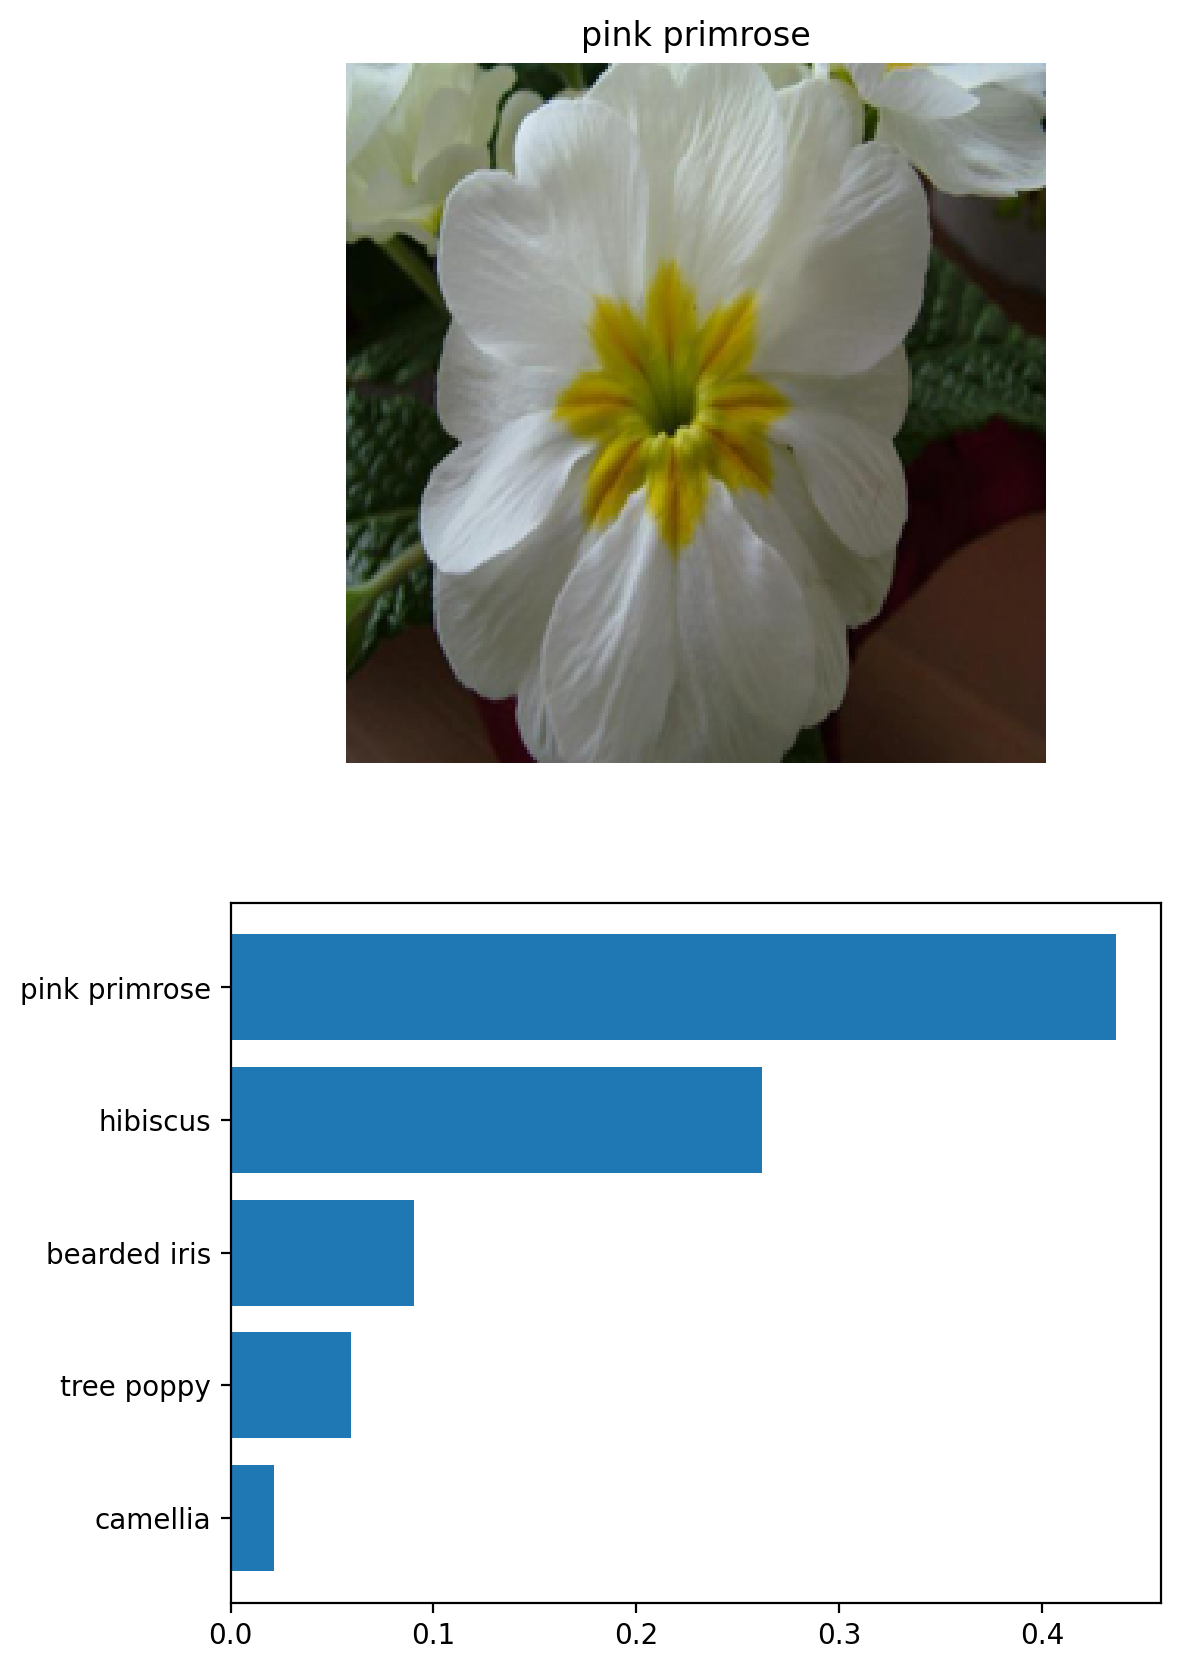

In [17]:
Prediction().plot_top_class(random_img_path, top_p, cls_label, cat_to_name)

In [ ]:
# python predict.py